In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm

# 1) Cargamos nuestros datos

In [2]:
df_final_demo = pd.read_csv('df_final_demo.csv')
df_final_experiment_clients = pd.read_csv('df_final_experiment_clients.csv')
df_final_web_data_1 = pd.read_csv('df_final_web_data_pt_1.csv')
df_final_web_data_2 = pd.read_csv('df_final_web_data_pt_2.csv')

# 2) Unificación y renombrado de columnas web
Concatenamos las dos partes de datos web y renombramos a nombres claros: `visita_id`, `cliente_disp_id`, `estado_proceso`, `fecha_hora`.


In [3]:
# 2. Unificamos los df_web y renombramos columnas
df_final_web_data = pd.concat([df_final_web_data_1, df_final_web_data_2], ignore_index=True)
df_final_web_data = df_final_web_data.rename(columns={
    'visit_id'    : 'visita_id',
    'visitor_id'  : 'cliente_disp_id',
    'process_step': 'estado_proceso',
    'date_time'   : 'fecha_hora'
})



# 3) Tipos, rango temporal y orden lógico del proceso
Pasamos `fecha_hora` a datetime, filtramos al rango del experimento y definimos el orden del proceso (`start` → `confirm`). Ordenamos por visita y tiempo.


In [4]:
# 3) Tipos, rango temporal y orden lógico de pasos
df_final_web_data['fecha_hora'] = pd.to_datetime(df_final_web_data['fecha_hora'], errors='coerce')

# Rango del experimento
start_date = '2017-03-15'
end_date   = '2017-06-20'
df_final_web_data = df_final_web_data[
    (df_final_web_data['fecha_hora'] >= start_date) &
    (df_final_web_data['fecha_hora'] <= end_date)
].copy()

# Orden de proceso
orden_pasos = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
df_final_web_data['estado_proceso'] = pd.Categorical(
    df_final_web_data['estado_proceso'], categories=orden_pasos, ordered=True
)
df_final_web_data = df_final_web_data.sort_values(['visita_id', 'fecha_hora']).reset_index(drop=True)


# 4) Limpieza/renombre de demografía
Renombramos columnas de la tabla demográfica y convertimos a enteros seguros (`Int64`). Excluimos géneros no informativos.


In [5]:
# 4) Limpieza / renombre de la tabla demográfica
df_final_demo = df_final_demo.rename(columns={
    'clnt_tenure_yr'   : 'años_cliente_vg',
    'clnt_tenure_mnth' : 'meses_cliente_vg',
    'gendr'            : 'genero',
    'clnt_age'         : 'edad',
    'num_accts'        : 'num_cuentas',
    'calls_6_mnth'     : 'llamadas_6_meses',
    'logons_6_mnth'    : 'logins_6_meses',
    'bal'              : 'saldo_total'
})

def cambio_entero(df, cols):
    df = df.copy()
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').round().astype('Int64')
    return df

df_final_demo = cambio_entero(df_final_demo, [
    'años_cliente_vg','meses_cliente_vg','num_cuentas',
    'llamadas_6_meses','logins_6_meses','edad'
])

# Filtramos géneros poco informativos
df_final_demo_1 = df_final_demo.query("genero not in ['U','other','X']").copy()


# 5) Limpieza de clientes del experimento
Normalizamos el nombre de la columna `variation` y eliminamos filas nulas.


In [6]:
# 5) Limpieza de la tabla de experimento
df_final_experiment_clients = df_final_experiment_clients.rename(columns={'Variation': 'variation'}).dropna()
df_final_experiment_clients


,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
50495,393005,Control
50496,2908510,Control
50497,7230446,Test
50498,5230357,Test


# 6) Merges: web + experimento + demografía
Unimos los datos web con la asignación de experimento y, después, con demografía. Mostramos un pequeño chequeo de columnas y cobertura de `variation`.


In [7]:
# 6) Merges: web + experimento + demografía
web     = df_final_web_data
clients = df_final_experiment_clients
demo    = df_final_demo_1
web_clients = web.merge(clients[['client_id','variation']], on='client_id', how='left')
df_master = web_clients.merge(demo, on='client_id', how='left')
df_master


,client_id,cliente_disp_id,visita_id,estado_proceso,fecha_hora,variation,años_cliente_vg,meses_cliente_vg,edad,genero,num_cuentas,saldo_total,llamadas_6_meses,logins_6_meses
0,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
1,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
2,9056452,306992881_89423906595,1000165_4190026492_760066,start,2017-06-04 01:07:29,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
3,9056452,306992881_89423906595,1000165_4190026492_760066,step_1,2017-06-04 01:07:32,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
4,9056452,306992881_89423906595,1000165_4190026492_760066,step_2,2017-06-04 01:07:56,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747568,7149380,483112224_46340533900,999992932_41666455053_671149,step_1,2017-06-06 15:46:24,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
747569,7149380,483112224_46340533900,999992932_41666455053_671149,step_2,2017-06-06 15:47:32,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
747570,7149380,483112224_46340533900,999992932_41666455053_671149,step_3,2017-06-06 16:01:46,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
747571,7149380,483112224_46340533900,999992932_41666455053_671149,confirm,2017-06-06 16:04:08,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>


# 7) Depuración general y orden final
Eliminamos nulos residuales, filtramos valores no válidos en `variation` y ordenamos por `visita_id` y `fecha_hora`.


In [8]:
# 7) Drop nulos básicos y orden final
df_master = df_master.dropna()
df_master = df_master[~df_master['variation'].astype(str).str.lower().isin(['nan'])]
df_master = df_master.sort_values(['visita_id', 'fecha_hora'])
df_master.head()

,client_id,cliente_disp_id,visita_id,estado_proceso,fecha_hora,variation,años_cliente_vg,meses_cliente_vg,edad,genero,num_cuentas,saldo_total,llamadas_6_meses,logins_6_meses
7,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,7,88,24,M,2,26436.73,6,9
8,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,7,88,24,M,2,26436.73,6,9
9,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,7,88,24,M,2,26436.73,6,9
10,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,7,88,24,M,2,26436.73,6,9
11,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,7,88,24,M,2,26436.73,6,9


# 8) Corrección clave: la visita debe empezar en `start`
Garantizamos que el **primer elemento** de cada `visita_id` sea `start`. Si no lo es, descartamos esa visita.


In [9]:
# 8)Asegurar que cada visita empieza en 'start'
prim_evento = (
    df_master
      .sort_values(['visita_id', 'fecha_hora'])
      .groupby('visita_id', as_index=False)
      .first()[['visita_id', 'estado_proceso']]
)
visitas_ok = prim_evento.loc[prim_evento['estado_proceso'].eq('start'), 'visita_id']
df_master = df_master[df_master['visita_id'].isin(visitas_ok)].copy()

# 9) Grupos de edad
Creamos una variable categórica `grupo_edad` para análisis demográfico por tramos de edad.


In [10]:
# 9) Grupos de edad
bins = [0, 18, 25, 35, 45, 55, 65, 80, float('inf')]
labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '66-80', '+80']
df_master['grupo_edad'] = pd.cut(df_master['edad'], bins=bins, labels=labels, right=True, include_lowest=True)
df_master[['edad','grupo_edad']].head()

,edad,grupo_edad
7,24,18-25
8,24,18-25
9,24,18-25
10,24,18-25
11,24,18-25


In [11]:
#Guardamos el csv final
df_master.to_csv('df_master.csv',index=False)

# 10) Comenzamos el análisis demográfico


Vamos a ver primero el número de clientes en cada grupo de edad.

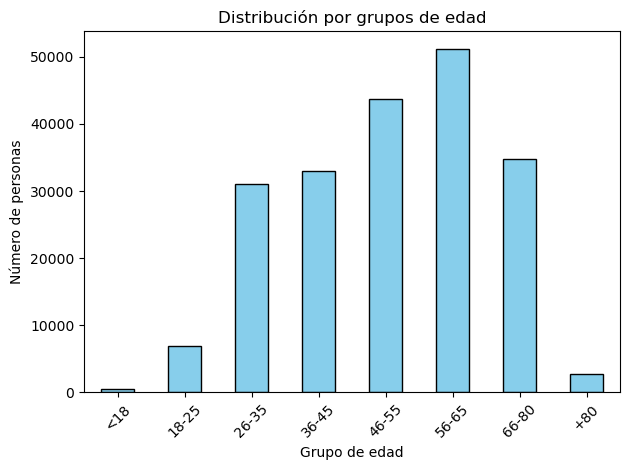

In [12]:
# Contamos cuántos hay en cada grupo de edad
conteo = df_master['grupo_edad'].value_counts().sort_index()

# Creamos el gráfico de barras
conteo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribución por grupos de edad")
plt.xlabel("Grupo de edad")
plt.ylabel("Número de personas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Vamos a ver la media de Saldo Total que tienen estos grupos de edad:

In [13]:
media_saldo = (
    df_master.groupby('grupo_edad', observed=False)['saldo_total']
    .mean()
    .reset_index()
    .sort_values('grupo_edad')
)
print(media_saldo)

  grupo_edad    saldo_total
0        <18   45716.201930
1      18-25   62547.311660
2      26-35   87785.428258
3      36-45  135254.150572
4      46-55  189428.955191
5      56-65  239083.287036
6      66-80  277750.434960
7        +80  328616.285346


Y su respectiva gráfica:

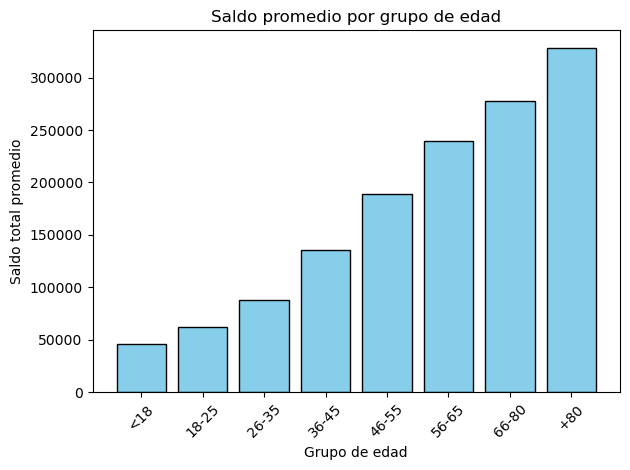

In [14]:
plt.bar(media_saldo['grupo_edad'], media_saldo['saldo_total'], color='skyblue', edgecolor='black')
plt.title("Saldo promedio por grupo de edad")
plt.xlabel("Grupo de edad")
plt.ylabel("Saldo total promedio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

De momento nos interesan cleintes entre 56 y 80 años ya que son los grupos que más media de saldo total tienen en sus cuentas respecto a  lo numerosos que son.

Vamos a ver ahora el género predominante de ese grupo

In [15]:
filtro_edad = df_master[df_master['grupo_edad'].isin(['56-65', '66-80'])]
porcentaje_sexo = filtro_edad['genero'].value_counts(normalize=True) * 100
porcentaje_sexo

genero
F    50.426197
M    49.573803
Name: proportion, dtype: float64

Y el saldo medio de cada uno

In [16]:
media_saldo = filtro_edad.groupby('genero')['saldo_total'].mean().round(2)
media_saldo

genero
F    181573.15
M    329091.97
Name: saldo_total, dtype: float64

Creamos un pie chart con el resultado

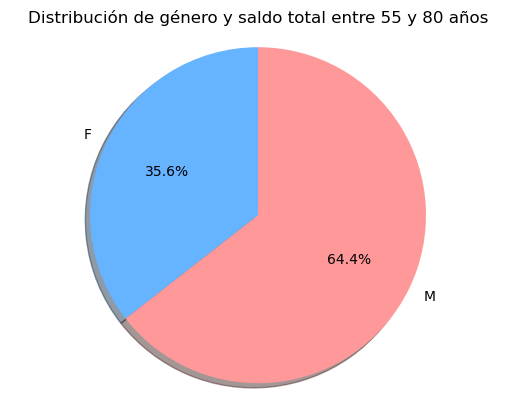

In [17]:
plt.pie(
    media_saldo,
    labels=media_saldo.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999'],
    shadow=True
)

plt.title("Distribución de género y saldo total entre 55 y 80 años")
plt.axis('equal')
plt.show()

Vemos que de media los hombres en ese rango de edad tienen casi 1/3 más de saldo total en sus cuentas. Por lo tanto, nos interesan más.

Nuestro Cliente Principal son varones entre 55 y 80 años. Primarán los que llevan más tiempo usando la aplicación o por el contrario llevarán poco?

In [18]:
filtro_hombres = df_master[(df_master['grupo_edad'].isin(['56-65', '66-80'])) &(df_master['genero'] == 'M')]

In [19]:
media_tiempo_app = filtro_hombres['años_cliente_vg'].mean()
print(media_tiempo_app,"años")

16.20872624912034 años


Y su respectiva gráfica:

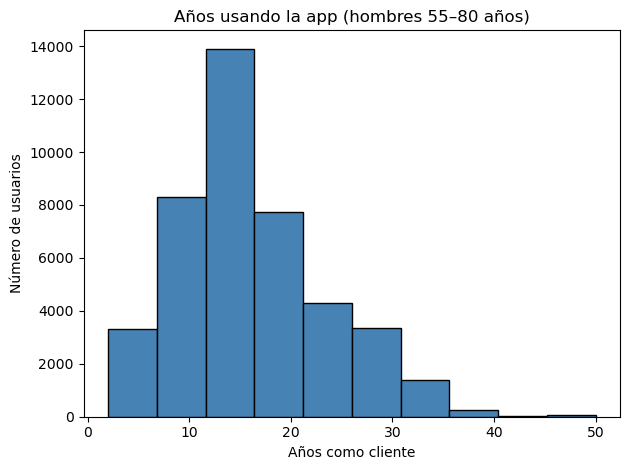

In [20]:
plt.hist(filtro_hombres['años_cliente_vg'], bins=10, color='steelblue', edgecolor='black')
plt.title("Años usando la app (hombres 55–80 años)")
plt.xlabel("Años como cliente")
plt.ylabel("Número de usuarios")
plt.tight_layout()
plt.show()

Por lo tanto nuestro perfil de Cliente Principal es un varón de entre 55 y 80 años que lleva varios años registrado.

In [21]:
from pathlib import Path
from datetime import datetime
# Carpeta ./exports/AAAA-MM-DD_HHMM
export_dir = Path("exports") / datetime.now().strftime("%Y-%m-%d_%H%M")
export_dir.mkdir(parents=True, exist_ok=True)
# Ruta de salida y guardado
out_path = export_dir / "df_master.csv"
df_master.to_csv(out_path, index=False, encoding="utf-8")
print(f":marca_de_verificación_blanca: Exportado: {out_path.resolve()}")

:marca_de_verificación_blanca: Exportado: C:\Users\andre\Desktop\Curso_Data_Analytics\5.Quinta Semana\Proyecto Vanguard\exports\2025-11-10_1801\df_master.csv
